# Using OpenAI Client to invoke Holo1 for a localization task

Holo1 is an Action Vision-Language Model (VLM) developed by [H Company](https://www.hcompany.ai/) for use in the Surfer-H web agent system. It is designed to interact with web interfaces like a human user. 

As part of a broader agentic architecture, Holo1 acts as a policy, localizer, or validator, helping the agent understand and act in digital environments.

This notebook demonstrates how to call Holo1 (3B or 7B) using OpenAI Client.

## Prerequisites

Before running this notebook, ensure you have:

- Holo1 served with vLLM (see the [deploy recipe](https://github.com/hcompai/hai-cookbook/blob/main/holo1/local/README.md))

## Contents

1. [Install required python dependencies](#1-install-required-python-dependencies)
2. [Prepare the Input Payload](#2-prepare-the-input-payload)
3. [Invoke Holo1 endpoint](#3-invoke-holo1-endpoint)
4. [Invoke Holo1 endpoint with structured output](#4-invoke-holo1-endpoint-with-structured-output)


## 1. Install required python dependencies

In [ ]:
%pip install -qU rich openai pydantic Pillow

In [2]:
import json
import rich
import re

from typing import Any, Literal
from PIL import Image
import pathlib as pl
import sys
from IPython.display import display

In [3]:
# Add directory to the Python path to import utils package
project_root_dir = pl.Path.cwd().resolve().parents[1]
sys.path.append(str(project_root_dir))

In [4]:
# Get cursor .png path
cursor_img_path = project_root_dir / "data" / "cursor_image_red.png"

# 2. Prepare the Input Payload

Holo1 models are served using vLLM as an OpenAI Server. 

In this example, Holo1 is prompted to identify the correct location to click in order to successfully select a date on the calendar.

**Important**: The input image must be resized using Qwen’s `smart_resize` method. This is crucial because vLLM performs its own internal resizing, which can alter the original image dimensions and lead to inaccurate or misaligned coordinate predictions from the model.

In [5]:
# Prepare inference request
from utils.image import smart_resize

# Load image
image_path = project_root_dir / "data" / "calendar_example.jpg"
image = Image.open(image_path)

# Resize the image so that predicted absolute coordinates match the size of the image.
resized_height, resized_width = smart_resize(height=image.height, width=image.width)
image = image.resize(size=(resized_width, resized_height), resample=None)

task = "Select July 14th as the check-out date"

## 3. Invoking Holo1 via API

Click(350, 342)

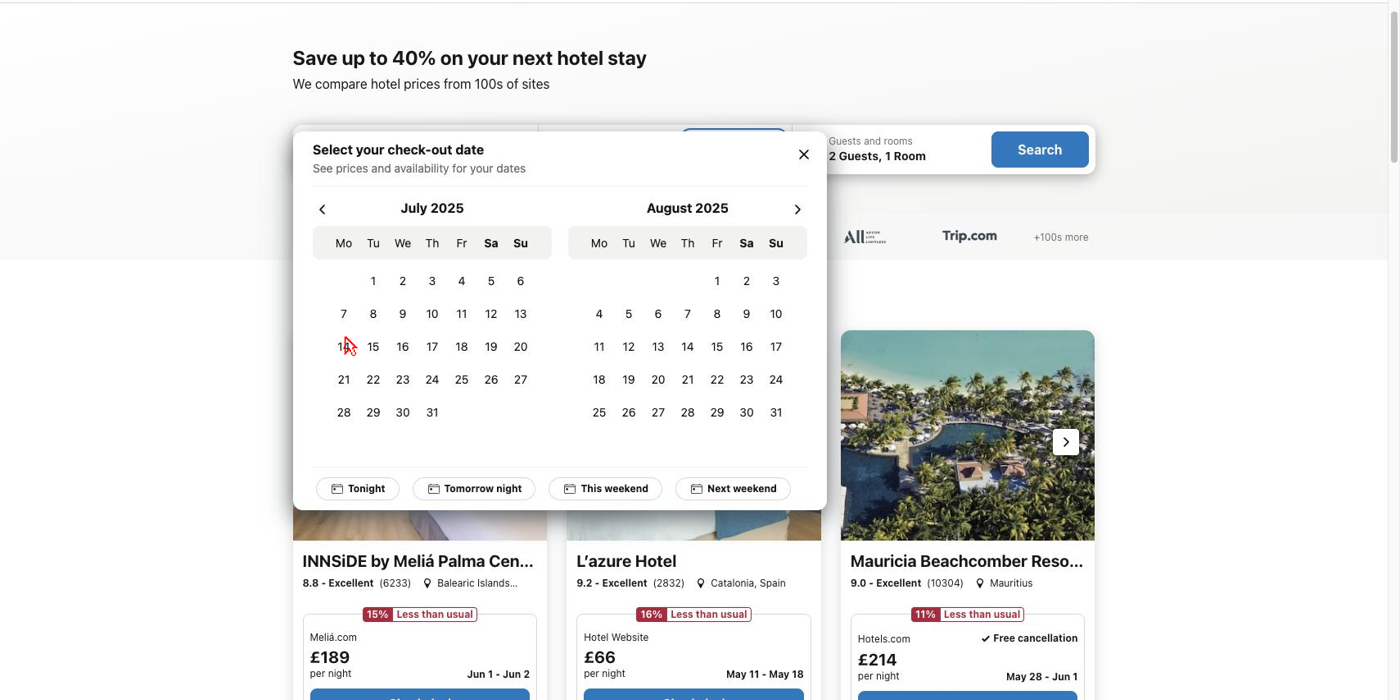

In [ ]:
from utils.image import draw_image_with_click
from openai import OpenAI
from utils.localization import build_localization_task_messages

MODEL_NAME = "HCompany/Holo1-3B"
BASE_URL = "http://localhost:8000/v1"
API_KEY = "EMPTY"

client = OpenAI(
    base_url=BASE_URL,
    api_key=API_KEY
)

chat_completion = client.chat.completions.create(
    model=MODEL_NAME,
    messages=build_localization_task_messages(
        task=task,
        image=image,
        image_format="JPEG",
    ),
    temperature=0,
)


rich.print(chat_completion.choices[0].message.content)


def extract_click(response: str) -> tuple[int, int]:
    """Extract the click position from the LLM response."""
    pattern = r"Click\(\s*(\d+)\s*,\s*(\d+)\s*\)"
    match = re.search(pattern, response)
    if match:
        x, y = map(int, match.groups())
        return x, y
    raise ValueError("No click position found in the response")


# Parse the output
click_str = chat_completion.choices[0].message.content
x, y = extract_click(click_str)

display(draw_image_with_click(image, x, y, cursor_img_path))

## 4. Invoking Holo1 via API with structured output

Holo1 served by vLLM supports structured output. In the following request, the output json schema will be provided as input of the request.

ClickAction(action='click', x=350, y=342)

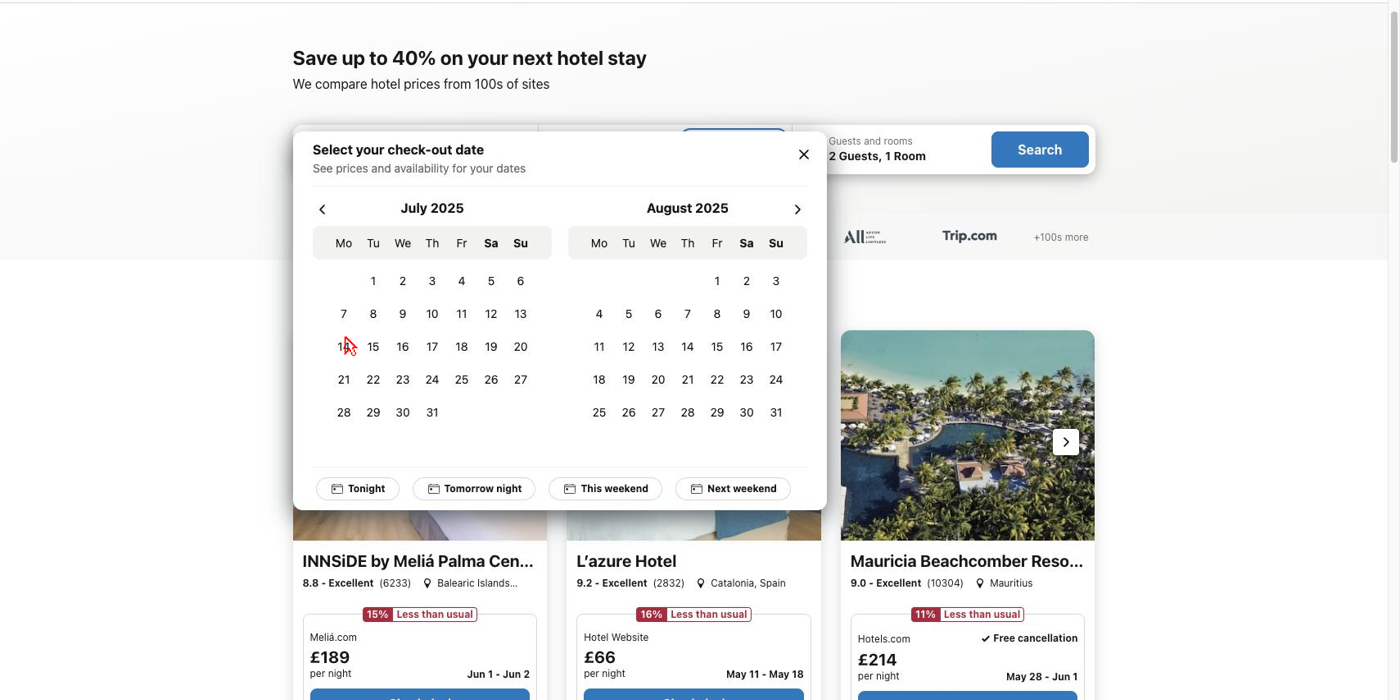

In [17]:

from openai import OpenAI
from utils.image import draw_image_with_click
from utils.localization import ClickAction, build_localization_task_messages_structured_output

MODEL_NAME = "HCompany/Holo1-3B"
BASE_URL = "http://localhost:8000/v1"
API_KEY = "EMPTY"

client = OpenAI(
    base_url=BASE_URL,
    api_key=API_KEY
)

chat_completion = client.chat.completions.create(
    model=MODEL_NAME,
    messages=build_localization_task_messages_structured_output(
        task=task,
        image=image,
        image_format="JPEG",
    ),
    temperature=0,
    extra_body={
        "guided_json": ClickAction.model_json_schema(),
    }
)

click = ClickAction(**json.loads(chat_completion.choices[0].message.content))
rich.print(click)

display(draw_image_with_click(image, click.x, click.y, cursor_img_path))